In [1]:

# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_IMAGE_DATA_FORMAT"] = "channels_first"
os.environ["KERAS_IMAGE_DIM_ORDERING"] = "th"
#os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
#import theano as th
#import theano.tensor as T
#from keras.utils import np_utils
import keras.models as models
from keras import Sequential
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras, bz2, tarfile

Using Theano backend.


In [2]:
if ("channels_first" != keras.backend.image_data_format()):
    print("ERROR: [%s] set it for Keras in  ~/.keras/keras.json file % keras.backend.image_data_format()")

In [3]:
# Load the dataset ...
#  You will need to seperately download or generate this file

Xd = cPickle.load(open("RML2014.04c_dict_cpfsk_gfsk.pkl","rb") )
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [4]:

# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [5]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(20000, 2, 128) [2, 128]


In [6]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
#model = Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Convolution2D(256, (1, 3), activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Convolution2D(80, (2, 3), activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1", kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense( len(classes) , name="dense2", kernel_initializer='he_normal' ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

#new_model = Sequential()
#new_model.add(model)
#new_model.add(Activation('softmax'))
#new_model.add(Reshape([len(classes)]))

#new_model.compile(loss='categorical_crossentropy', optimizer='adam')
#new_model.summary()

#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1, 132)       

In [7]:
# Set up some params 
nb_epoch = 50    # number of epochs to train on
batch_size = 1024  # training batch size

In [8]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
#    show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 20000 samples, validate on 20000 samples
Epoch 1/50
 - 242s - loss: 0.6933 - acc: 0.5017 - val_loss: 0.6935 - val_acc: 0.4961
Epoch 2/50
 - 236s - loss: 0.6932 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.4961
Epoch 3/50
 - 236s - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6934 - val_acc: 0.4961
Epoch 4/50
 - 237s - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6933 - val_acc: 0.4961
Epoch 5/50
 - 232s - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4961
Epoch 6/50
 - 232s - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6932 - val_acc: 0.4961
Epoch 7/50
 - 231s - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.4961
Epoch 8/50
 - 237s - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6930 - val_acc: 0.4961
Epoch 9/50
 - 235s - loss: 0.6928 - acc: 0.5140 - val_loss: 0.6924 - val_acc: 0.5279
Epoch 10/50
 - 227s - loss: 0.6903 - acc: 0.5773 - val_loss: 0.6852 - val_acc: 0.6586
Epoch 11/50
 - 228s - loss: 0.6668 - acc: 0.6217 - val_loss: 0.6239 - val_acc: 0.6729
Epoch 12/50
 

In [9]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

[0.3131478112541139, 0.7866500007629394]


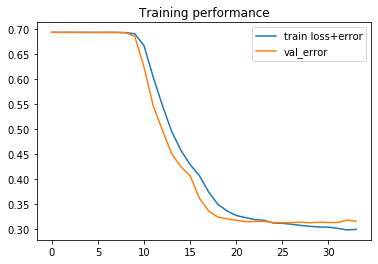

In [10]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [11]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

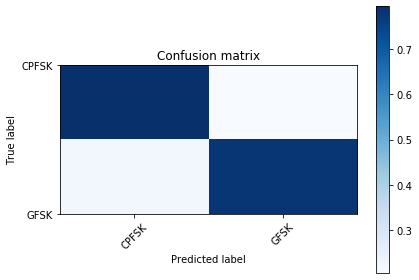

In [12]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.42972699696663297
Overall Accuracy:  0.4503441494591937
Overall Accuracy:  0.4558093346573982
Overall Accuracy:  0.4333683105981112
Overall Accuracy:  0.4462809917355372
Overall Accuracy:  0.5024875621890548
Overall Accuracy:  0.5731108930323847
Overall Accuracy:  0.6753507014028056
Overall Accuracy:  0.8138613861386138
Overall Accuracy:  0.9415262636273538
Overall Accuracy:  0.9877049180327869
Overall Accuracy:  0.9990059642147118
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  0.9990356798457087


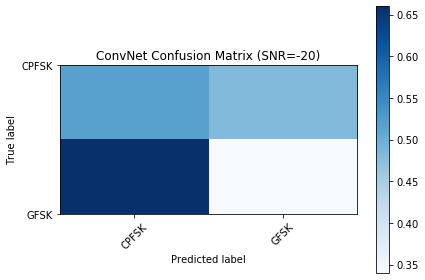

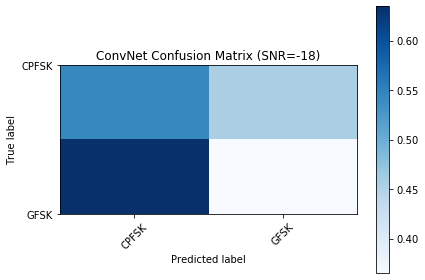

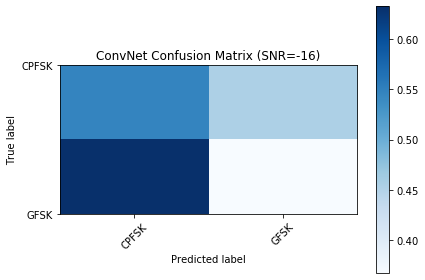

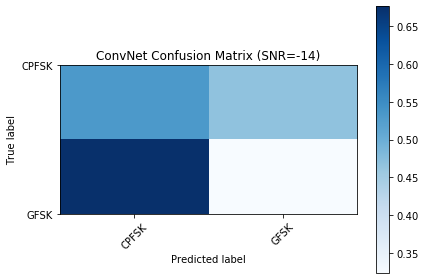

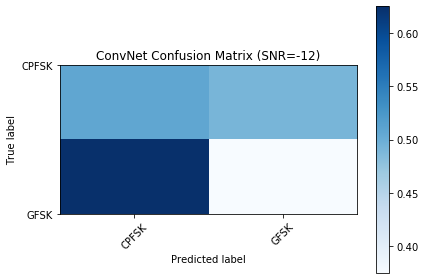

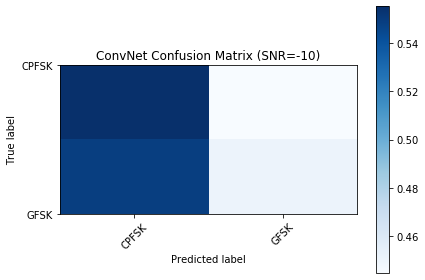

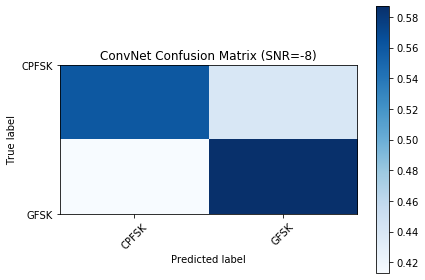

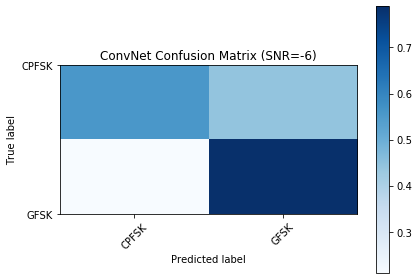

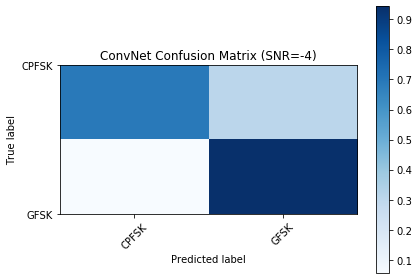

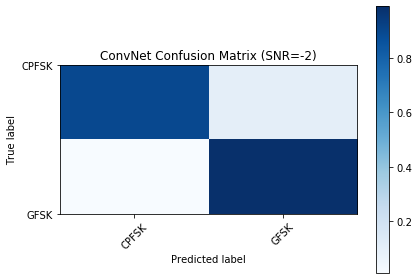

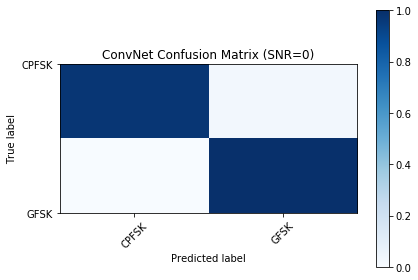

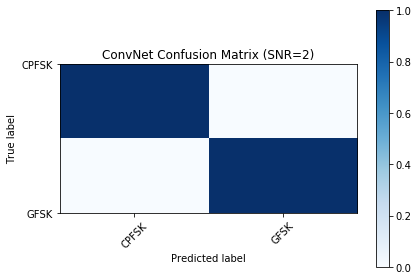

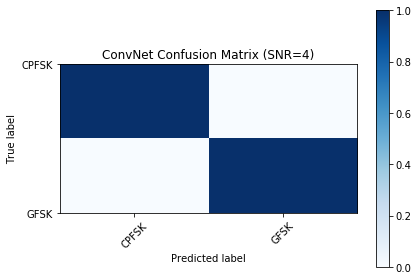

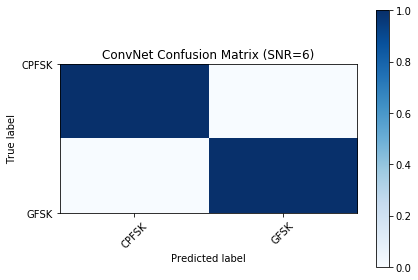

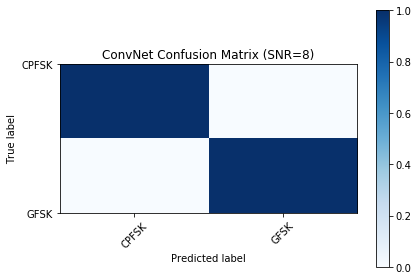

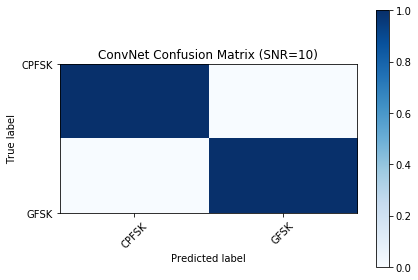

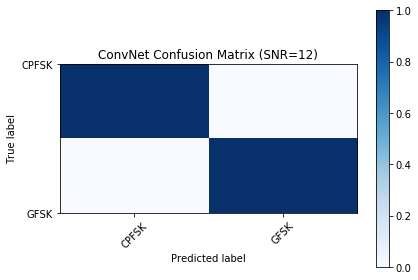

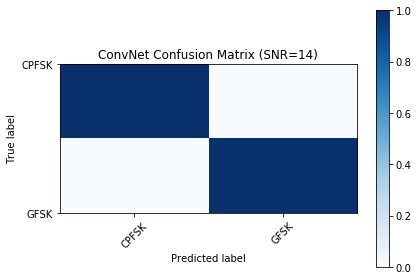

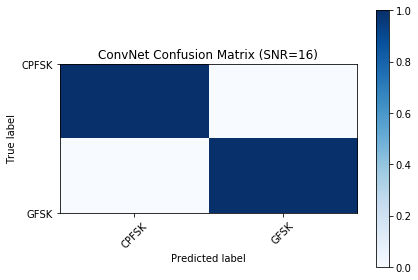

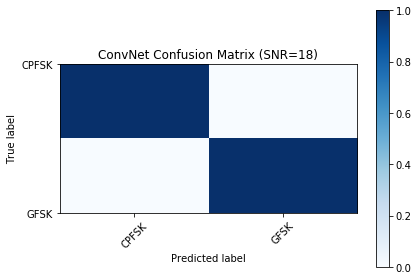

In [13]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [14]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )
fd.close()

{-20: 0.42972699696663297, -18: 0.4503441494591937, -16: 0.4558093346573982, -14: 0.4333683105981112, -12: 0.4462809917355372, -10: 0.5024875621890548, -8: 0.5731108930323847, -6: 0.6753507014028056, -4: 0.8138613861386138, -2: 0.9415262636273538, 0: 0.9877049180327869, 2: 0.9990059642147118, 4: 1.0, 6: 1.0, 8: 1.0, 10: 1.0, 12: 1.0, 14: 1.0, 16: 1.0, 18: 0.9990356798457087}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

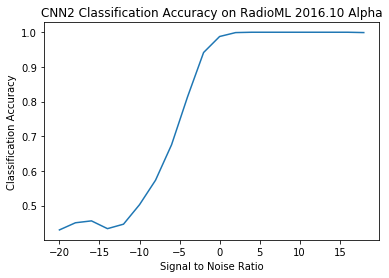

In [15]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

In [16]:
print("Done")

Done
